In [1]:
#!kaggle competitions download -c facial-keypoints-detection

In [2]:
# if keypoint dataset is unzipped
#!unzip facial-keypoints-detection.zip
#!ls

In [3]:
# if training is unzipped
#!unzip training.zip
#!ls

In [4]:
# I took this kaggle problem
# I tried to solve it in pytorch

#https://www.kaggle.com/karanjakhar/facial-keypoint-detection

import pandas as pd
# from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import random
import torch

In [5]:
print(torch.__version__)

1.7.0


In [6]:
data = pd.read_csv('training.csv') 
print(data.columns)
print(data.head())
print(data.isnull().any().value_counts())
data.fillna(method = 'ffill',inplace = True)
print(data.isnull().any().value_counts())

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')
   left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274  

In [7]:
num_train_data = len(data)
pixel_list = []
for i in range(num_train_data):
    row = data['Image'][i].split(' ')
    pixel = ['0' if x == '' else x for x in row] # handling empty image pixels
    pixel_list.append(pixel)

In [8]:
#images = data['Image'].replace(r'^\s*$', '0')

In [9]:
# Pytorch takes channels in the second dimension. For that, I swap axes (dimensions)
image_tensor = np.array(pixel_list, dtype = 'float')
print(np.shape(image_tensor))
image_tensor = image_tensor.reshape(-1, 96, 96, 1)
image_tensor = np.swapaxes(image_tensor, 2, 3)
image_tensor = np.swapaxes(image_tensor, 1, 2)
print(np.shape(image_tensor))

(7049, 9216)
(7049, 1, 96, 96)


In [10]:
labels = data.drop('Image',axis = 1)

label_list = []
for i in range(num_train_data):
    label = labels.iloc[i,:]
    label_list.append(label)
label_tensor = np.array(label_list,dtype = 'float')

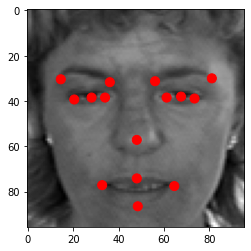

In [11]:
from matplotlib.pyplot import Circle

index = random.randint(0,1000)

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(image_tensor[index].reshape(96,96),cmap='gray')

for xx, yy in label_tensor[index].reshape((15,2)):
    circ = Circle((xx,yy),2,color='red')
    ax.add_patch(circ)

In [12]:
train_len = 7000
img_and_label = []
for i in range(train_len):
    img_and_label.append([image_tensor[i], label_tensor[i]])

# we use Dataloader objects in pytorch to easily iterate on our dataset while performing training loops
train_loader = torch.utils.data.DataLoader(img_and_label, shuffle=True, batch_size=500)
img1, lbl1 = next(iter(train_loader))
print("first training batch: \n" + "input shape: " + str(img1.shape) + "\n" + "label shape: " + str(lbl1.shape))

test_data = []
for i in range(train_len, num_train_data): # since we have no labels for real test data!
    test_data.append([image_tensor[i], label_tensor[i]])

test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=500)
test1, tlbl1 = next(iter(test_loader))
print("test batch: \n" + "input shape: " + str(test1.shape) + "\n" + "label shape: " + str(tlbl1.shape))

first training batch: 
input shape: torch.Size([500, 1, 96, 96])
label shape: torch.Size([500, 30])
test batch: 
input shape: torch.Size([49, 1, 96, 96])
label shape: torch.Size([49, 30])


In [13]:
import torch.nn as nn
import torch.nn.functional as F

# we write our networks as class instances. dont forget to inherit from nn.Module
class Net(nn.Module):
    # we always need an init method to define our output matrices (similar to nodes in graph)
    def __init__(self):
        super(Net, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.leaky_relu = nn.LeakyReLU(0.1)
        
        self.conv1 = nn.Conv2d(1, 32, 5) #1, 32
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 5) #32, 64
        self.conv2_bn = nn.BatchNorm2d(64)

        #self.conv3 = nn.Conv2d(16, 32, 5) #64, 128
        #self.conv3_bn = nn.BatchNorm2d(32)

        #self.conv4 = nn.Conv2d(32, 64, 5) #128, 256
        #self.conv4_bn = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(64 * 21 * 21, 120)
        self.fc1_bn = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc2_bn = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 30)
        
    # we always need an forward method to draw our computational graph (similar to completing the graph with edges)
    def forward(self, x):

        x = self.max_pool(self.leaky_relu(self.conv1_bn(self.conv1(x))))
        x = self.max_pool(self.leaky_relu(self.conv2_bn(self.conv2(x))))
        #x = self.leaky_relu(self.conv3_bn(self.conv3(x)))
        #x = self.max_pool(self.leaky_relu(self.conv4_bn(self.conv4(x))))

        # vectorize (flatten)
        x = x.reshape(-1, 64 * 21 * 21)
        #x = torch.flatten(x)
        #x = torch.reshape(x, (input_shape, -1))
        x = torch.sigmoid(self.fc1_bn(self.fc1(x)))        
        x = torch.sigmoid(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        return x

inzvaNet = Net()

In [14]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(inzvaNet.parameters(), lr=0.0001, momentum=0.9)

In [15]:
inzvaNet = inzvaNet.float()

In [16]:
#we get info on our gpu, put it in the variable "device"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

#we carry our model into gpu
inzvaNet.to(device)

cpu


Net(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=28224, out_features=120, bias=True)
  (fc1_bn): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2_bn): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=30, bias=True)
)

In [17]:
# our training loop
# check for free memory option -> this code may lead to memory explosion if grads are not cleared, etc.
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0

    # here we use the dataloader object. it performs .next() operation in each iteration of the loop
    # we also group our batches with numbers. we do this with enumerate. we do this so we can know in which batch we are 
    for i, data in enumerate(train_loader, start = 0):
        # get the inputs; data is a list of [inputs, labels]

        #inputs, labels = data
        inputs, labels = data[0].float().to(device), data[1].float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = inzvaNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print('Epoch %d Loss: %.3f' %
                  (epoch + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Epoch 1 Loss: 1.336
Epoch 2 Loss: 1.309
Epoch 3 Loss: 1.261
Epoch 4 Loss: 1.207
Epoch 5 Loss: 1.155
Epoch 6 Loss: 1.100
Epoch 7 Loss: 1.050
Epoch 8 Loss: 0.992
Epoch 9 Loss: 0.939
Epoch 10 Loss: 0.885
Finished Training


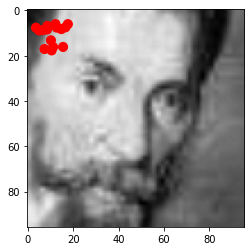

In [33]:
rand_test = random.randint(0,49)
test_batch = next(iter(test_loader))

test_batch_data = test_batch[0].float().to(device)
test_batch_label = test_batch[1].float().to(device)

preds = inzvaNet(test_batch_data).cpu()

fig, ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(test_batch_data[rand_test].cpu().view((96,96)), cmap = 'gray')

for xx, yy in preds[rand_test].reshape((15,2)):
    circ = Circle((xx, yy), 2, color='red')
    ax.add_patch(circ)

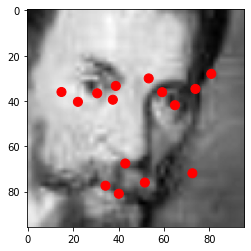

In [34]:
fig, ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(test_batch_data[rand_test].cpu().view((96,96)), cmap = 'gray')

for xx, yy in test_batch_label[rand_test].reshape((15,2)):
    circ = Circle((xx, yy), 2, color='red')
    ax.add_patch(circ)